In [1]:
import os
import glob 
import numpy as np 
import matplotlib.pyplot as plt 

In [90]:
import h5py

In [18]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

In [4]:
embedding_files = sorted(glob.glob("../../bba_28_case1/outlier_runs/embeddings-*.npy"))

In [13]:
embeddings = []
for embedding_file in embedding_files: 
    embed = np.load(embedding_file)
    embeddings.append(embed)

embeddings = np.vstack(embeddings)

In [94]:
anton_embeddings = np.load("../../bba-anton-embeddings.npy")
anton_embeddings.shape

(1114112, 10)

In [26]:
embedding_label = [anton_embeddings.shape[0], embeddings.shape[0]]

In [97]:
h5 = h5py.File("/homes/heng.ma/Research/covid19/adrp/SBinfoPerf/cvae/latent.h5", "r")
h5.keys()

<KeysViewHDF5 ['latent']>

In [98]:
h5['latent'].shape

(480000, 3)

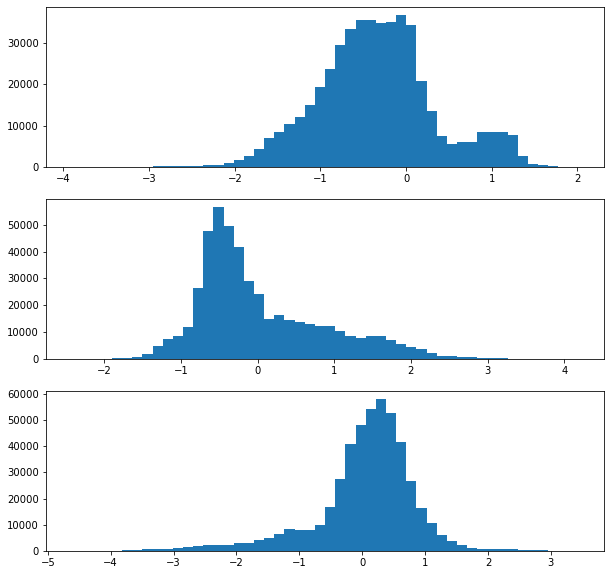

In [100]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()): 
    _ = ax.hist(h5['latent'][:, i], bins=50) 

In [27]:
embedings_all = np.vstack([embeddings, anton_embeddings])

In [65]:
rmsd_anton = np.load("../traj_analysis/rmsd.npy")
rmsd_anton.shape

(1114545, 3)

In [72]:
from sklearn.manifold import TSNE
cm_tsne = TSNE(n_components=2).fit_transform(anton_embeddings[:1114000:100])

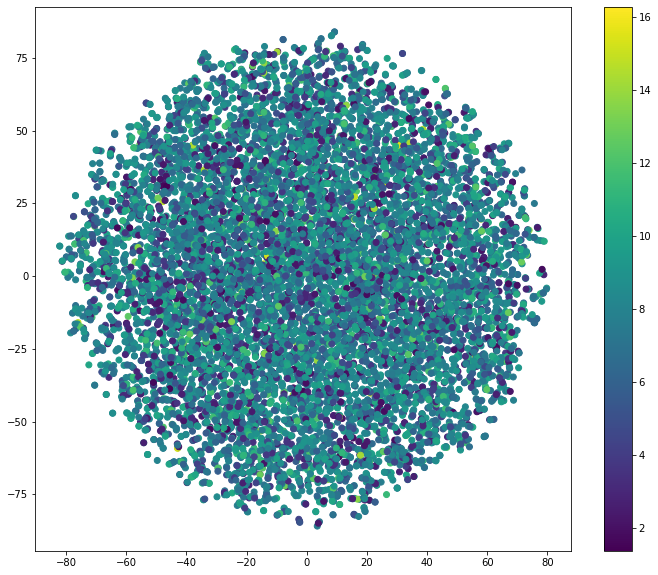

In [80]:
plt.subplots(figsize=(12,10))
plt.scatter(cm_tsne[:, 0], cm_tsne[:, 1], c=rmsd_anton[:1114000:100,2])
plt.colorbar()

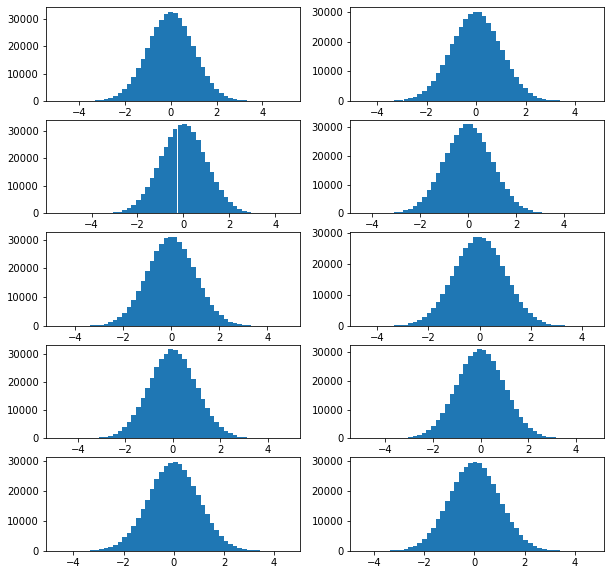

In [95]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()): 
    _ = ax.hist(embeddings[:, i], bins=50) 

In [37]:
# KMeans clustering 
print('Initiating standard kmeans...')
kmeans = KMeans(n_clusters=1000, random_state=42).fit(embedings_all[::10]) 
kmeans_labels = kmeans.labels_ 

Initiating standard kmeans...


In [45]:
np.save('kmeans.npy', kmeans_labels)

In [39]:
len(set(kmeans_labels[int(embedding_label[0]/10):]))

1000

In [40]:
traj_dict = {"anton": 1114112, 'case1_long': 406144}

In [46]:
traj_cluster_hist = {} 
kmeans = kmeans_labels
# mbkmeans = h5_kmeans[u'mbkmeans'].value
for traj in sorted(traj_dict): 
    len_traj = traj_dict[traj] 
    current_mem = set() 
    current_pop = []
    for i in np.arange(len_traj//10): 
        current_cluster, kmeans = kmeans[0], kmeans[1:] 
        current_mem.add(current_cluster)
        current_pop.append(len(current_mem)) 
    traj_cluster_hist[traj] = current_pop 

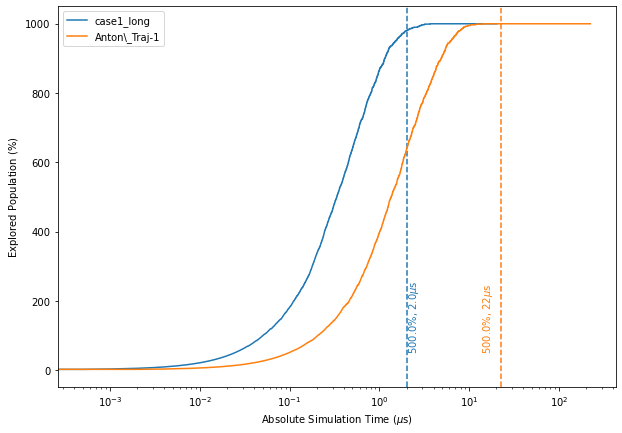

In [76]:
fig, ax = plt.subplots(figsize=(10,7)) 

pop_hist = traj_cluster_hist['case1_long'] 
# pop_hist = pop_hist[22800:]
ax.plot(np.arange(len(pop_hist)) * 0.5/1000, np.array(pop_hist, dtype=float), 
        label=r'case1_long') 
ax.text(len(pop_hist) * 0.05/1000, 60, 
        r'{:.1f}$\%$, {:.1f}$\mu$s'.format(pop_hist[-1]/2.0, len(pop_hist) * 0.05 /1000), 
        color='tab:blue', rotation='vertical')
ax.axvline(x=len(pop_hist) * 0.05/1000, ls='--', color='tab:blue') 


pop_hist = traj_cluster_hist['anton']
ax.plot(np.arange(len(pop_hist)) * 2 /1000, np.array(pop_hist, dtype=float), label='Anton\_Traj-1') 
ax.text(len(pop_hist) * 0.2/1000/1.65, 60, 
        r'{:.1f}$\%$, {:.0f}$\mu$s'.format(pop_hist[-1]/2.0, len(pop_hist) * 0.2 /1000), 
        color='tab:orange', rotation='vertical')
ax.axvline(x=len(pop_hist) * 0.2/1000, ls='--', color='tab:orange') 

# pop_hist = traj_cluster_hist['../../1FME/contact_maps_1FME-1.h5']
# ax.plot(np.arange(len(pop_hist)) * 0.2 /1000, np.array(pop_hist, dtype=float)/2, label='Anton\_Traj-2') 
# ax.text(len(pop_hist) * 0.2/1000/1.65, 60, 
#         r'{:.1f}$\%$, {:.0f}$\mu$s'.format(pop_hist[-1]/2.0, len(pop_hist) * 0.2 /1000),
#         color='tab:green', rotation='vertical')
# ax.axvline(x=len(pop_hist) * 0.2/1000, ls='--', color='tab:green') 
# # ax.axvline(x=len(pop_hist) * 0.2/1000) 


ax.legend(loc='best') 
# ax.set_xlim([1e-2, 250]) 
# ax.set_ylim([0, 100])
ax.set_xscale('log') 
ax.set_xlabel(r'Absolute Simulation Time ($\mu$s)') 
ax.set_ylabel('Explored Population ($\%$)') 
fig.savefig('bba_include_training.pdf', bbox_inches='tight')
